In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [3]:
data_noise = 0.08

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

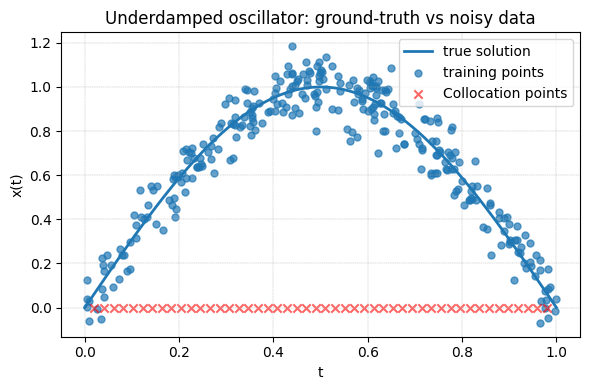

In [4]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [ ]:
# from draft import VIBPINN
from utils_uq_dropout import DropoutPINN
vi_poisson_model = DropoutPINN(pde, 1, [16, 32, 32, 16], 1)
loss_dict = vi_poisson_model.fit_do_pinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=20000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0,)

Using device: cpu
ep     1 | L=5.25e+01 | data=9.39e-01 | pde=4.77e+01  ic=0.00e+00  bc=8.81e-02 | lr=3.00e-03
ep   500 | L=2.54e+00 | data=9.95e-02 | pde=1.94e+00  ic=0.00e+00  bc=1.06e-01 | lr=3.00e-03
ep  1000 | L=1.82e+00 | data=5.89e-02 | pde=1.28e+00  ic=0.00e+00  bc=2.42e-01 | lr=3.00e-03
ep  1500 | L=2.07e+00 | data=8.95e-02 | pde=1.56e+00  ic=0.00e+00  bc=6.38e-02 | lr=3.00e-03
ep  2000 | L=2.38e+00 | data=7.61e-02 | pde=1.82e+00  ic=0.00e+00  bc=1.76e-01 | lr=3.00e-03
ep  2500 | L=1.11e+00 | data=7.55e-02 | pde=7.10e-01  ic=0.00e+00  bc=2.56e-02 | lr=3.00e-03
ep  3000 | L=1.54e+00 | data=8.38e-02 | pde=1.11e+00  ic=0.00e+00  bc=1.49e-02 | lr=3.00e-03
ep  3500 | L=1.60e+00 | data=6.78e-02 | pde=1.18e+00  ic=0.00e+00  bc=8.33e-02 | lr=3.00e-03
ep  4000 | L=1.62e+00 | data=7.10e-02 | pde=1.12e+00  ic=0.00e+00  bc=1.43e-01 | lr=3.00e-03
ep  4500 | L=2.08e+00 | data=6.53e-02 | pde=1.52e+00  ic=0.00e+00  bc=2.29e-01 | lr=3.00e-03
ep  5000 | L=1.27e+00 | data=5.41e-02 | pde=8.88e-01

In [ ]:
x_grid = torch.linspace(0, 1, 100).view(-1, 1)
pred_set = vi_poisson_model.predict(x_grid, n_samples=1000)

([0.7084184288978577], [], [0.06561543792486191], [47.750038146972656])

In [ ]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_train, Y=Y_train)